In [ ]:
import numpy as np
import pylab as plt
from matplotlib.transforms import ScaledTranslation

In [ ]:
# Generate data to fit
def f(x):
    return np.sin(2 * np.pi * x)+ 0.3 * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
# Set seed for reproducibility
np.random.seed(1234)
x = np.linspace(0, 1, 10)
y = f(x)

In [ ]:
class RegressorGP():

    def __init__(self, kernel, noise=0):
        # Kernel function
        self.kernel = kernel
        # Error in data
        self.noise = noise
        self.trained = False


    def train(self, x, y):
        '''
        Train a GP Regressor on x and y data. Prefactors K with
        Cholesky decomposition.
        '''
        self.x = x
        self.y = y
        self.n = len(x)
        # Compute kernel matrix (K) for training data
        K = self.kernel(*np.meshgrid(x, x))
        # Cholesky decomposition of K
        self.L = np.linalg.cholesky(K + self.noise**2 * np.eye(self.n))
        # Save K^(-1) y
        self.alpha = np.linalg.solve(self.L.T, np.linalg.solve(self.L, self.y))
        self.trained = True


    def predict(self, test):
        '''
        Returns condtional distribution of regressor on a test set of x values
        '''
        if not self.trained:
            raise ValueError("Train model before prediction")

        # Conditional mean and variance arrays for test set
        mean = np.empty(len(test))
        var = np.empty(len(test))

        for i, t in enumerate(test):
            # Compute convaraince vector of t with every x in the train set
            k_t = self.kernel(t, self.x)
            # Solve for mean and covariance posteriors
            mean[i] = k_t @ self.alpha
            v = np.linalg.solve(self.L, k_t)
            var[i] = self.kernel(t, t) - v @ v

        return mean, np.sqrt(var)


    def log_likelihood(self):
        '''
        Returns log likelyhood for given kernel and training data
        '''
        if not self.trained:
            raise ValueError("Train model before assessing log likelihood")

        data_fit = -0.5 * self.y @ self.alpha
        complexity_penalty = -np.sum(np.log(np.diag(self.L)))
        constant = -0.5 * self.n * np.log(2 * np.pi)
        return data_fit + complexity_penalty + constant

In [ ]:
def matern_3half(x1, x2, sigma=1, rho=1):
    # Matérn 3/2 kernel
    d = abs(x1 - x2)
    y = (d*(3)**0.5)/rho
    return sigma**2 * (1 + y) * np.exp(-y)

In [ ]:
def score_hyperparameters(sigma, rho, noise=0.3):
    # Given hyperparameters sigma and constant
    # Scores a model using log likelihood function on X and Y data
    kernel = lambda x1, x2: matern_3half(x1, x2, sigma=sigma, rho=rho)
    gp = RegressorGP(kernel, noise=noise)
    gp.train(x, y)
    return gp.log_likelihood()

# Reconstruct the log likelihood contours for kernels
# with different sigma and constant values
N = 100
P = np.logspace(-3, 1, N, base=2.7182)
S = np.logspace(-2, 2, N, base=2.7182)
Z = np.empty((N, N))

for i, sigma in enumerate(S):
    for j, rho in enumerate(P):
          Z[i][j] = score_hyperparameters(sigma, rho)

# Find max log likelihood and arg max values of sigma and c
max_idx = np.argmax(Z)
p_idx = max_idx // N
s_idx = max_idx % N

sigma_max, rho_max = S[s_idx], P[p_idx]

In [ ]:
# Matern Kernel
kernel = lambda x1, x2: matern_3half(x1, x2, sigma=sigma_max, rho=rho_max)
# Train a model
gp_model = RegressorGP(kernel, 0.3)
gp_model.train(x, y)
# Predict over a test set
test_set = np.linspace(0, 1, 100)
mean, sd = gp_model.predict(test_set)

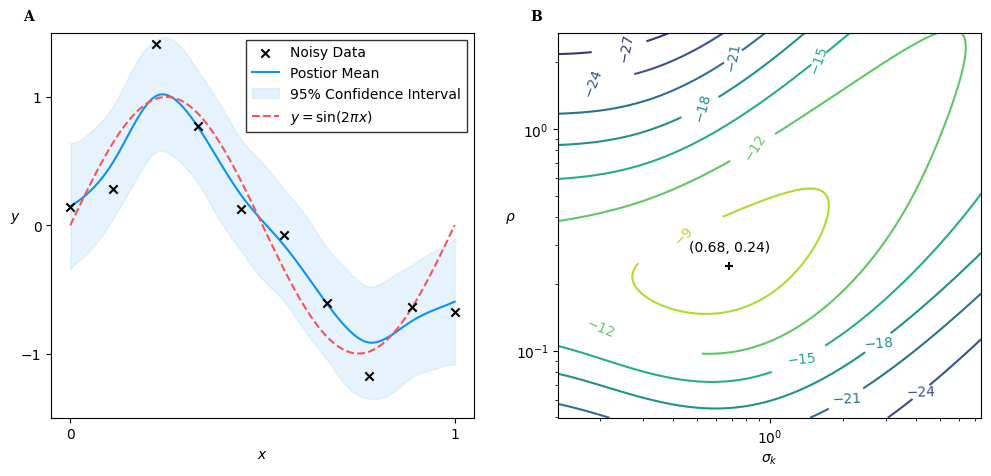

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Plot predictions
ax1.scatter(x, y, color='black', marker='x', label='Noisy Data', zorder=4)
# GP Posterior
ax1.plot(test_set, mean, color='#0D92F4', label='Postior Mean')
ax1.fill_between(test_set, mean - 1.96*sd, mean+1.96*sd, alpha=0.1, color='#0D92F4', label='95% Confidence Interval')
# True function
ax1.plot(test_set, np.sin(2 * np.pi * test_set), color='#F95454', ls='dashed', label='$y = \sin(2 \pi x)$')
# Formating
ax1.legend(fancybox=False, edgecolor='black')
ax1.set_ylim(-1.5, 1.5)
ax1.set_xticks([0, 1])
ax1.set_yticks([-1, 0, 1])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$', rotation=0);

# Add contours
CS = ax2.contour(S, P, Z)
ax2.clabel(CS, inline=True, fontsize=10)
# Plot max
ax2.scatter([sigma_max], [rho_max], marker='+', color='black')
ax2.annotate(f'({round(sigma_max, 2)}, {round(rho_max, 2)})',
    (sigma_max, rho_max), ha='center', xytext=(sigma_max, rho_max+0.04))
# Formating
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('$\sigma_k$')
ax2.set_ylabel(r'$\rho$', rotation=0);

# Labels
for label, ax in zip(['A', 'B'], (ax1, ax2)):
    ax.text(
        0.0, 1.0, label, transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='medium', weight='bold', va='bottom', fontfamily='serif')

plt.savefig('Figure1.png', dpi=400)